# 论文17：变分有损自编码器
## Xi Chen, Diederik P. Kingma, et al. (2016)

### VAE：具有学习潜在空间的生成模型

将深度学习与变分推理结合用于生成建模。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# 设置中文字体
plt.rcParams["font.family"] = ["Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False

## 变分自编码器 (VAE) 基础

VAE学习：
- **编码器**：q(z|x) - 近似后验
- **解码器**：p(x|z) - 生成模型

**损失**：ELBO = 重构损失 + KL散度

In [2]:
def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

class VAE:
    def __init__(self, input_dim, hidden_dim, latent_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # Encoder: x -> h -> (mu, log_var)
        self.W_enc_h = np.random.randn(input_dim, hidden_dim) * 0.1
        self.b_enc_h = np.zeros(hidden_dim)
        
        self.W_mu = np.random.randn(hidden_dim, latent_dim) * 0.1
        self.b_mu = np.zeros(latent_dim)
        
        self.W_logvar = np.random.randn(hidden_dim, latent_dim) * 0.1
        self.b_logvar = np.zeros(latent_dim)
        
        # Decoder: z -> h -> x_recon
        self.W_dec_h = np.random.randn(latent_dim, hidden_dim) * 0.1
        self.b_dec_h = np.zeros(hidden_dim)
        
        self.W_recon = np.random.randn(hidden_dim, input_dim) * 0.1
        self.b_recon = np.zeros(input_dim)
    
    def encode(self, x):
        """
        Encode input to latent distribution parameters
        
        Returns: mu, log_var of q(z|x)
        """
        h = relu(np.dot(x, self.W_enc_h) + self.b_enc_h)
        mu = np.dot(h, self.W_mu) + self.b_mu
        log_var = np.dot(h, self.W_logvar) + self.b_logvar
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick: z = mu + sigma * epsilon
        where epsilon ~ N(0, I)
        """
        std = np.exp(0.5 * log_var)
        epsilon = np.random.randn(*mu.shape)
        z = mu + std * epsilon
        return z
    
    def decode(self, z):
        """
        Decode latent code to reconstruction
        
        Returns: reconstructed x
        """
        h = relu(np.dot(z, self.W_dec_h) + self.b_dec_h)
        x_recon = sigmoid(np.dot(h, self.W_recon) + self.b_recon)
        return x_recon
    
    def forward(self, x):
        """
        Full forward pass
        """
        # Encode
        mu, log_var = self.encode(x)
        
        # Sample latent
        z = self.reparameterize(mu, log_var)
        
        # Decode
        x_recon = self.decode(z)
        
        return x_recon, mu, log_var, z
    
    def loss(self, x, x_recon, mu, log_var):
        """
        VAE loss = Reconstruction Loss + KL Divergence
        """
        # Reconstruction loss (binary cross-entropy)
        recon_loss = -np.sum(
            x * np.log(x_recon + 1e-8) + 
            (1 - x) * np.log(1 - x_recon + 1e-8)
        )
        
        # KL divergence: KL(q(z|x) || p(z))
        # where p(z) = N(0, I)
        # KL = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        kl_loss = -0.5 * np.sum(1 + log_var - mu**2 - np.exp(log_var))
        
        return recon_loss + kl_loss, recon_loss, kl_loss

# Create VAE
input_dim = 16  # e.g., 4x4 image flattened
hidden_dim = 32
latent_dim = 2  # 2D for visualization

vae = VAE(input_dim, hidden_dim, latent_dim)
print(f"VAE created:")
print(f"  Input: {input_dim}")
print(f"  Hidden: {hidden_dim}")
print(f"  Latent: {latent_dim}")

VAE created:
  Input: 16
  Hidden: 32
  Latent: 2


## 生成合成数据 (Generate Synthetic Data)

简单的4x4模式用于演示

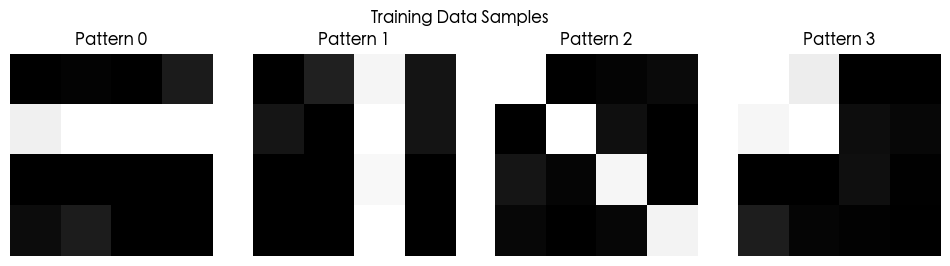

Generated 200 training samples


In [3]:
def generate_patterns(num_samples=100):
    """
    Generate simple 4x4 binary patterns
    """
    data = []
    
    for i in range(num_samples):
        pattern = np.zeros((4, 4))
        
        if i % 4 == 0:
            # Horizontal line
            pattern[1:2, :] = 1
        elif i % 4 == 1:
            # Vertical line
            pattern[:, 2:3] = 1
        elif i % 4 == 2:
            # Diagonal
            np.fill_diagonal(pattern, 1)
        else:
            # Corner square
            pattern[:2, :2] = 1
        
        # Add small noise
        noise = np.random.randn(4, 4) * 0.05
        pattern = np.clip(pattern + noise, 0, 1)
        
        data.append(pattern.flatten())
    
    return np.array(data)

# Generate training data
X_train = generate_patterns(200)

# Visualize samples
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i].reshape(4, 4), cmap='gray', vmin=0, vmax=1)
    ax.set_title(f'Pattern {i}')
    ax.axis('off')
plt.suptitle('Training Data Samples')
plt.show()

print(f"Generated {len(X_train)} training samples")

## 测试前向传播和损失 (Test Forward Pass and Loss)

Forward pass:
  Input shape: (1, 16)
  Latent mu: [[-0.07013642 -0.03605331]]
  Latent log_var: [[ 0.1023022  -0.07757268]]
  Latent z: [[ 0.20568416 -1.91144632]]
  Reconstruction shape: (1, 16)

Losses:
  Total: 11.2752
  Reconstruction: 11.2680
  KL Divergence: 0.0073


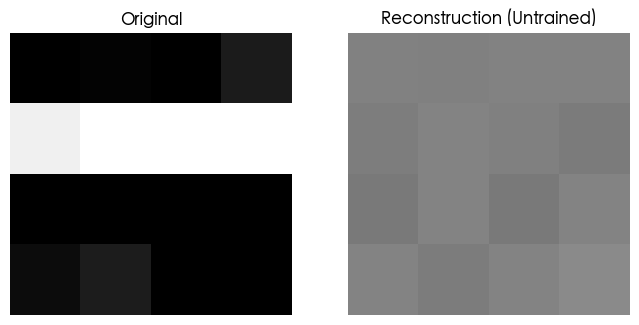

In [4]:
# Test on a single example
x = X_train[0:1]
x_recon, mu, log_var, z = vae.forward(x)

total_loss, recon_loss, kl_loss = vae.loss(x, x_recon, mu, log_var)

print(f"Forward pass:")
print(f"  Input shape: {x.shape}")
print(f"  Latent mu: {mu}")
print(f"  Latent log_var: {log_var}")
print(f"  Latent z: {z}")
print(f"  Reconstruction shape: {x_recon.shape}")
print(f"\nLosses:")
print(f"  Total: {total_loss:.4f}")
print(f"  Reconstruction: {recon_loss:.4f}")
print(f"  KL Divergence: {kl_loss:.4f}")

# Visualize reconstruction
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(x.reshape(4, 4), cmap='gray', vmin=0, vmax=1)
ax1.set_title('Original')
ax1.axis('off')

ax2.imshow(x_recon.reshape(4, 4), cmap='gray', vmin=0, vmax=1)
ax2.set_title('Reconstruction (Untrained)')
ax2.axis('off')

plt.show()

## 可视化潜在空间 (Visualize Latent Space)

由于latent_dim=2，我们可以可视化学习到的表示

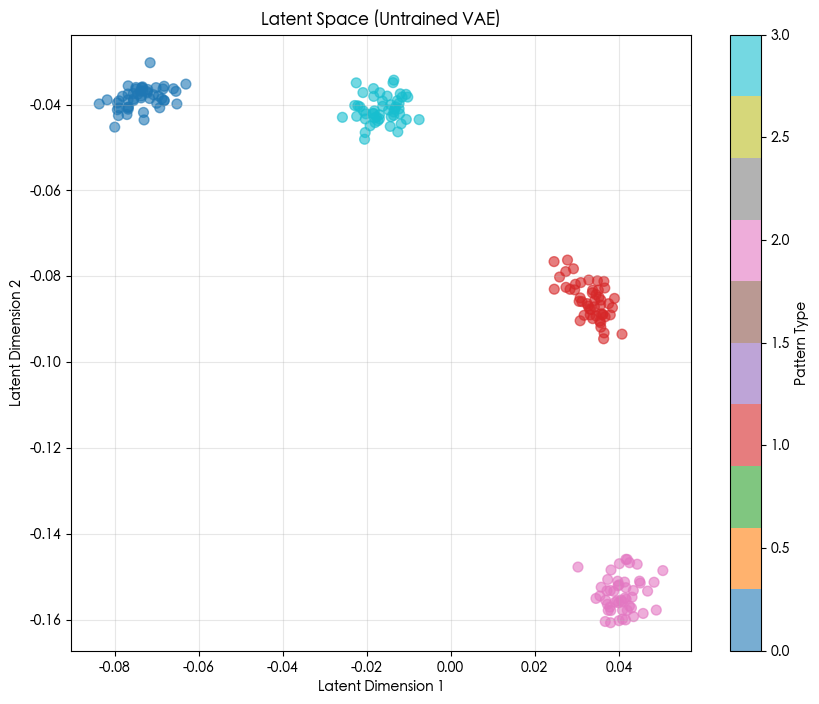

Latent space visualization shows distribution of encoded patterns


In [5]:
# Encode all training data
latent_codes = []
pattern_types = []

for i, x in enumerate(X_train):
    mu, log_var = vae.encode(x.reshape(1, -1))
    latent_codes.append(mu[0])
    pattern_types.append(i % 4)

latent_codes = np.array(latent_codes)
pattern_types = np.array(pattern_types)

# Plot latent space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    latent_codes[:, 0], 
    latent_codes[:, 1], 
    c=pattern_types, 
    cmap='tab10', 
    alpha=0.6,
    s=50
)
plt.colorbar(scatter, label='Pattern Type')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space (Untrained VAE)')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Latent space visualization shows distribution of encoded patterns")

## 从先验采样并生成 (Sample from Prior and Generate)

采样 z ~ N(0, I) 并解码以生成新样本

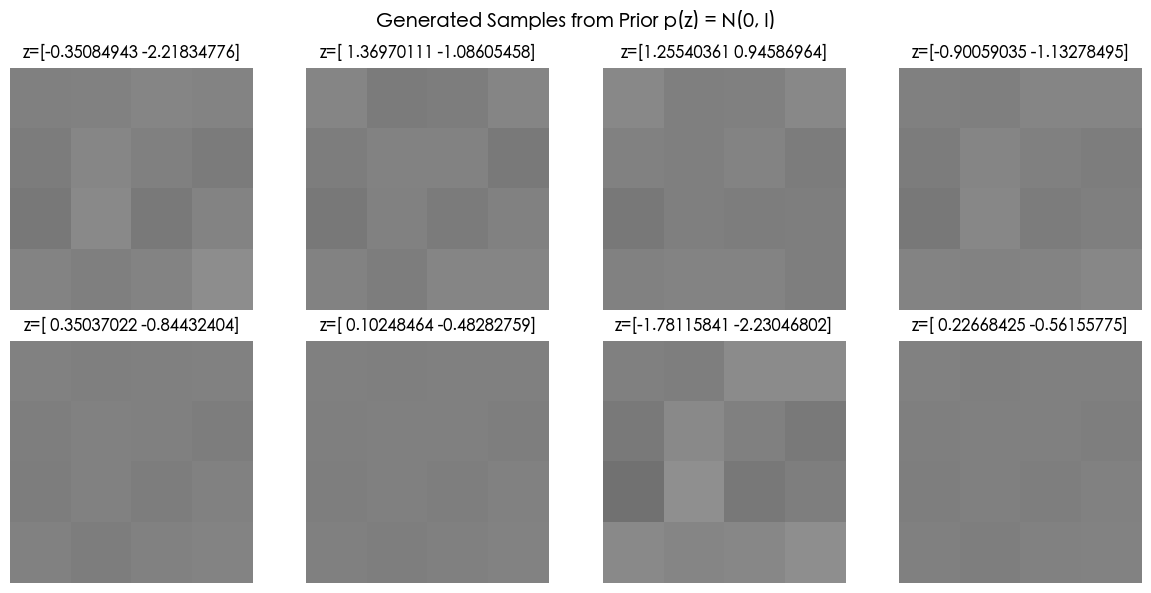

In [6]:
# Sample from standard normal prior
num_samples = 8
z_samples = np.random.randn(num_samples, latent_dim)

# Generate samples
generated = []
for z in z_samples:
    x_gen = vae.decode(z.reshape(1, -1))
    generated.append(x_gen[0])

# Visualize generated samples
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(generated[i].reshape(4, 4), cmap='gray', vmin=0, vmax=1)
    ax.set_title(f'z={z_samples[i][:2]}')
    ax.axis('off')

plt.suptitle('Generated Samples from Prior p(z) = N(0, I)', fontsize=14)
plt.tight_layout()
plt.show()

## 潜在空间中的插值 (Interpolation in Latent Space)

在潜在空间中的两点之间平滑插值

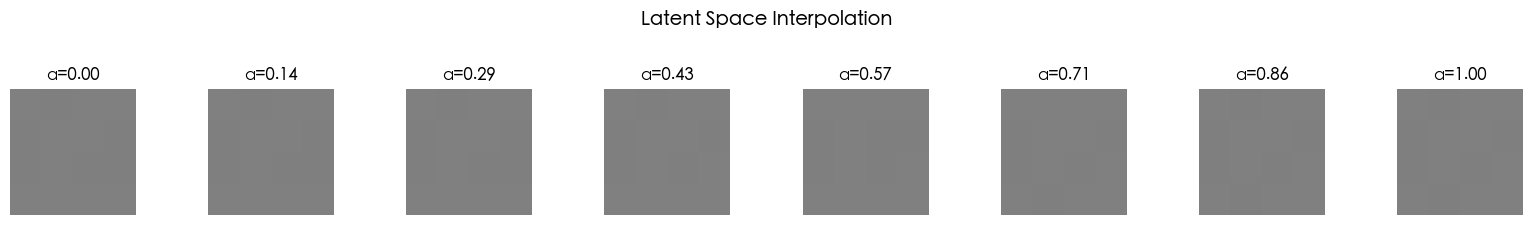

Smooth transitions show continuity in latent space


In [7]:
# Encode two different patterns
x1 = X_train[0:1]  # Pattern type 0
x2 = X_train[1:2]  # Pattern type 1

mu1, _ = vae.encode(x1)
mu2, _ = vae.encode(x2)

# Interpolate
num_steps = 8
interpolated = []

for alpha in np.linspace(0, 1, num_steps):
    z_interp = (1 - alpha) * mu1 + alpha * mu2
    x_interp = vae.decode(z_interp)
    interpolated.append(x_interp[0])

# Visualize interpolation
fig, axes = plt.subplots(1, num_steps, figsize=(16, 2))

for i, ax in enumerate(axes):
    ax.imshow(interpolated[i].reshape(4, 4), cmap='gray', vmin=0, vmax=1)
    ax.set_title(f'α={i/(num_steps-1):.2f}')
    ax.axis('off')

plt.suptitle('Latent Space Interpolation', fontsize=14, y=1.1)
plt.tight_layout()
plt.show()

print("Smooth transitions show continuity in latent space")

## 重参数化技巧可视化 (Reparameterization Trick Visualization)

/Users/guchen/repo_own/sutskever-30-implementations-zhCN/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Heiti TC.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/guchen/repo_own/sutskever-30-implementations-zhCN/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Heiti TC.
  fig.canvas.print_figure(bytes_io, **kw)


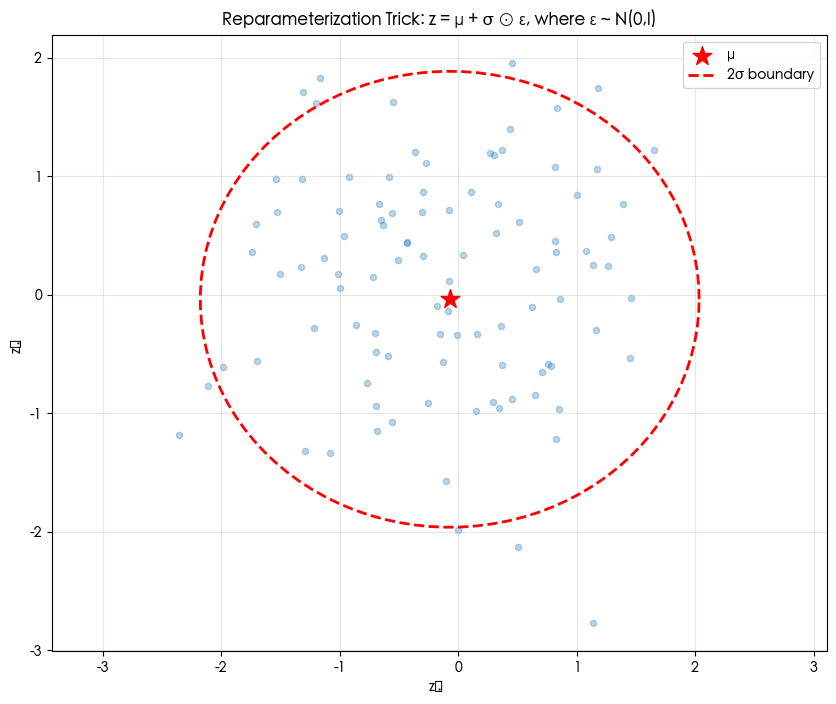

μ = [-0.07013642 -0.03605331]
σ = [1.05248191 0.96195622]
Sample mean: [-0.13728599  0.11355179]
Sample std: [0.92251123 0.92858669]


In [8]:
# Show multiple samples from same distribution
x = X_train[0:1]
mu, log_var = vae.encode(x)

# Sample multiple times
num_samples = 100
z_samples = []
for _ in range(num_samples):
    z = vae.reparameterize(mu, log_var)
    z_samples.append(z[0])

z_samples = np.array(z_samples)

# Plot distribution
plt.figure(figsize=(10, 8))
plt.scatter(z_samples[:, 0], z_samples[:, 1], alpha=0.3, s=20)
plt.scatter(mu[0, 0], mu[0, 1], color='red', s=200, marker='*', label='μ', zorder=5)

# Draw ellipse for 2 standard deviations
std = np.exp(0.5 * log_var[0])
theta = np.linspace(0, 2*np.pi, 100)
ellipse_x = mu[0, 0] + 2 * std[0] * np.cos(theta)
ellipse_y = mu[0, 1] + 2 * std[1] * np.sin(theta)
plt.plot(ellipse_x, ellipse_y, 'r--', label='2σ boundary', linewidth=2)

plt.xlabel('z₁')
plt.ylabel('z₂')
plt.title('Reparameterization Trick: z = μ + σ ⊙ ε, where ε ~ N(0,I)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

print(f"μ = {mu[0]}")
print(f"σ = {std}")
print(f"Sample mean: {z_samples.mean(axis=0)}")
print(f"Sample std: {z_samples.std(axis=0)}")

## 关键要点 (Key Takeaways)

### VAE架构 (VAE Architecture)：
1. **编码器**：q_φ(z|x) - 将输入映射到潜在分布
2. **重参数化**：z = μ + σ ⊙ ε（使反向传播成为可能）
3. **解码器**：p_θ(x|z) - 从潜在代码生成输出

### 损失函数 (ELBO)：
```
L = E[log p(x|z)] - KL(q(z|x) || p(z))
  = 重构损失 - KL散度
```

### KL散度 (KL Divergence)：
- 正则化潜在空间使其接近先验 p(z) = N(0, I)
- 防止过拟合
- 确保平滑的潜在空间

### 重参数化技巧 (Reparameterization Trick)：
- 使采样可微分
- z = μ(x) + σ(x) ⊙ ε，其中 ε ~ N(0, I)
- 梯度通过 μ 和 σ 流动

### 特性 (Properties)：
- **生成性**：可以采样新数据
- **连续潜在空间**：平滑插值
- **概率性**：对不确定性建模
- **解耦表示**：（使用 β-VAE 等）

### 应用 (Applications)：
- 图像生成
- 降维
- 半监督学习
- 异常检测
- 数据增强

### 变体 (Variants)：
- **β-VAE**：加权的KL用于解耦
- **条件VAE**：条件化生成
- **层次VAE**：多个潜在层级
- **VQ-VAE**：离散潜在变量